# Reinforcement Learning Project: Control in a Continuous Action Space with DDPG

In this project, we will explore the Deep Deterministic Policy Gradient (DDPG) algorithm, which is designed to handle continuous action spaces in Reinforcement Learning. We will use the [Pendulum-v1](https://www.gymlibrary.dev/environments/classic_control/pendulum/) environment implemented in OpenAI Gym to implement the DDPG algorithm from scratch to solve the classical control problem of stabilizing an inverted pendulum. Throughout the development, we will incrementally build the components of DDPG and analyze their importance for correct and effective learning. 

This Jupyter notebook contains our implementation and report for this project. Do not forget to remove the report parts before submitting the notebook.

The instructions are available in `Miniproject_DDPG.pdf` file.

In [ ]:
import numpy as np
from scipy import stats
import gym
from helpers import NormalizedEnv

import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

import copy

from tqdm import tqdm


Global Instances

In [ ]:
# Select device: 'cpu' or 'cuda'
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print("Using device:", device)

# Create environement instance, an instance of the Pendulum-v1 environment wrapped in a NormalizedEnv class
# to normalize the action space between -1 and 1
env = gym.make('Pendulum-v1', render_mode='rgb_array')
env = NormalizedEnv(env)

# Number of steps per episode, see documentation of the Pendulum-v1 environment
n_steps = 200

# Toolbox

## Policies

In [ ]:
# TODO docstring
class Agent:
    def __init__(self, env: NormalizedEnv) -> None:
        """Abstract agent class."""
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.shape[0]
        
    def compute_action(self, state: np.ndarray) -> np.ndarray:
        raise NotImplementedError
    
class RandomAgent(Agent):
    def __init__(self, env: NormalizedEnv) -> None:
        super().__init__(env)
        
    def compute_action(self, state: np.ndarray) -> np.ndarray:
        size = state.shape[:-1] + (self.action_size,)
        return np.random.uniform(-1, 1, size=size)
    
class HeuristicPendulumAgent(Agent):
    def __init__(self, env: NormalizedEnv, torque_intensity: float=1.0) -> None:
        super().__init__(env)
        self.torque_intensity = torque_intensity
        
    def compute_action(self, state: np.ndarray) -> np.ndarray:
        """Compute the action to apply to the environment.

        When the pendulum is in the lower half of the domain, applies a fixed torque in the same direction as the pendulum's angular velocity.
        When the pendulum is in the upper half of the domain, applies a fixed torque in the opposite direction as the pendulum's angular velocity.
        """
        action = np.where(state[..., [0]] < 0, # If the pendulum is in the lower half of the circle
                        np.sign(state[..., [2]]) * self.torque_intensity, 
                        -np.sign(state[..., [2]]) * self.torque_intensity)
        return action

## Simulation

In [ ]:
def compute_return_mean_std(agent: Agent, num_episodes: int = 10, env: NormalizedEnv = env) -> float:
    """Run the agent for `num_episodes` episodes and return the average return and its standard deviation."""
    returns = np.empty(num_episodes)
    for episode in range(num_episodes):
        state, _ = env.reset()
        cumulative_reward = 0
        while True:
            # Simulation step
            action = agent.compute_action(state)
            state, reward, _, trunc, _ = env.step(action)
            cumulative_reward += reward
            if trunc:
                break
        returns[episode] = cumulative_reward
    return np.mean(returns), np.std(returns)

def animation(filename: str, agent: Agent, env: NormalizedEnv = env) -> None:
    """Run the agent for one episode and save the frames as a gif."""
    state, _ = env.reset()
    frames = []
    while True:
        action = agent.compute_action(state)
        state, _, _, trunc, _ = env.step(action)
        frames.append(env.render())
        if trunc:
            break

    frames = np.array(frames)
    frames = [Image.fromarray(frame) for frame in frames]
    frames[0].save(filename + ".gif", save_all=True, append_images=frames[1:], duration=50, loop=0)

## Replay Buffer

In [ ]:
class ReplayBuffer:
    def __init__(self, capacity: int) -> None:
        """Buffer to store transitions.

        A transition is a tuple (state, action, reward, next_state, trunc) where:
            state (np.ndarray[(3,), np.float32]): State of the environment.
            action (np.ndarray[(1,), np.float32]): Action applied to the environment.
            reward (np.ndarray[(1,), np.float32]): Reward obtained after applying the action.
            next_state (np.ndarray[(3,), np.float32]): State of the environment after applying the action.
            trunc (np.ndarray[(1,), np.bool]): Boolean indicating if the episode is truncated.
        
        The buffer is implemented as 5 (one for each element of a transition) cyclic numpy arrays of shape 
        (capacity, *) where * is the shape of the corresponding element of a transition.
        When the buffer is full, the oldest transitions are dropped.
        
        Args:
            capacity (int): Capacity of the buffer.
        """
        self.capacity = capacity 
        self.states = np.empty((capacity, 3), np.float32)
        self.actions = np.empty((capacity, 1), np.float32)
        self.rewards = np.empty((capacity, 1), np.float32)
        self.next_states = np.empty((capacity, 3), np.float32)
        self.truncs = np.empty((capacity, 1), bool)
        # Index of the next transition to be stored
        self.index = 0
        # Current size of the buffer
        self.size = 0

    def append(self, transition):
        """Add a transition to the buffer.
        
        See constructor docstring for explanation of a transition.
        """
        # Add transition to current index
        self.states[self.index] = transition[0]
        self.actions[self.index] = transition[1]
        self.rewards[self.index] = transition[2]
        self.next_states[self.index] = transition[3]
        self.truncs[self.index] = transition[4]
        # Update index
        self.index = (self.index + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def sample(self, batch_size: int):
        """Sample a batch of size `batch_size` of transitions from the buffers."""
        indexes = np.random.choice(self.size, batch_size, replace=False)
        return self[indexes]

    def __len__(self) -> int:
        return self.size
    
    def __getitem__(self, slice):
        return (self.states[slice], 
                self.actions[slice], 
                self.rewards[slice], 
                self.next_states[slice], 
                self.truncs[slice])


## Networks and Learning Rules

In [ ]:
class QNetwork(nn.Module):
    def __init__(self, state_size: int=env.observation_space.shape[0], action_size: int=env.action_space.shape[0]):
        """QNetwork. Maps (state, action) pairs to Q-values."""
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size + action_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, state: torch.Tensor, action: torch.Tensor) -> torch.Tensor:
        """Forward pass of the network.

        Args:
            state (torch.Tensor): State tensor
            action (torch.Tensor): Action tensor

        Returns:
            q_value (torch.Tensor): Q-value tensor
        """
        x = torch.cat([state, action], dim=-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def TD_learning_update(q_network: QNetwork, 
                       agent: Agent, 
                       optimizer: torch.optim.Optimizer, 
                       transitions: tuple, 
                       gamma: float) -> float:
    """Perform a 1-step TD-learning update for a batch of transitions."""
    states = transitions[0]
    actions = transitions[1]
    rewards = transitions[2]
    next_states = transitions[3]
    truncs = transitions[4]

    # Convert the numpy arrays to torch tensors
    states_t = torch.from_numpy(states).to(device)
    actions_t = torch.from_numpy(actions).to(device)
    rewards_t = torch.from_numpy(rewards).to(device)
    next_states_t = torch.from_numpy(next_states).to(device)
    truncs_t = torch.from_numpy(truncs).to(device)


    with torch.no_grad():
        next_actions = agent.compute_action(next_states)
        next_actions_t = torch.as_tensor(next_actions).to(device, dtype=torch.float32)
        # Naive next Q-values (i.e. without taking truncation into account)
        naive_next_qs = q_network(next_states_t, next_actions_t)
        # Actual next Q-values (i.e. taking truncation into account)
        next_qs = torch.where(truncs_t, 
                              torch.zeros_like(rewards_t), 
                              naive_next_qs)
        gamma = torch.tensor(gamma, dtype=torch.float32)
        targets = rewards_t + gamma * next_qs

    loss = F.mse_loss(q_network(states_t, actions_t), targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

In [ ]:
def train(agent: Agent,
          q_network: QNetwork, 
          q_optimizer: torch.optim.Optimizer,
          n_episodes: int=1000, 
          batch_size: int=128, 
          gamma: float=0.99, 
          logging_interval: int=10, 
          capacity: int=10000, 
          env: NormalizedEnv=env,
          n_steps: int=n_steps, 
          verbose: bool=True) -> np.ndarray:
    """Train the DDPG agent.

    Args:
        agent (Agent): Agent to train
        q_network (QNetwork): Q-network
        q_optimizer (torch.optim.Optimizer): Optimizer for the Q-network
        n_episodes (int, optional): Number of episodes to train for. Defaults to 1000.
        batch_size (int, optional): Batch size for training. Defaults to 128.
        gamma (float, optional): Discount factor. Defaults to 0.99.
        logging_interval (int, optional): Logging interval. Defaults to 10.
        capacity (int, optional): Capacity of the replay buffer. Defaults to 10000.
        env (NormalizedEnv, optional): Environment. Defaults to env.
        n_steps (int, optional): Number of steps per episode. Defaults to n_steps.
        verbose (bool, optional): Whether to print training logs. Defaults to True.
    
    Returns:
        losses (np.ndarray): Losses
    """
    replay_buffer = ReplayBuffer(capacity=capacity)
    losses = np.empty((n_episodes, n_steps))
    progress_bar = tqdm(range(n_episodes), desc="Training", disable=not verbose, unit="episode")
    with progress_bar as episodes:
        for episode in episodes:
            state, _ = env.reset()
            step = 0
            while True:
                # Simulation step
                action = agent.compute_action(state)
                next_state, reward, _, trunc, _ = env.step(action)
                transition = (state, action, reward, next_state, trunc)
                replay_buffer.append(transition)
                # Training step
                if len(replay_buffer) >= batch_size:
                    transitions = replay_buffer.sample(batch_size)
                    loss = TD_learning_update(q_network, agent, q_optimizer, transitions, gamma)
                    losses[episode, step] = loss
                else:
                    losses[episode, step] = np.nan

                if trunc:
                    break
                state = next_state
                step += 1    
            episodes.set_postfix_str(f"Loss: {np.nanmean(losses[episode])}")
    return losses
    

## 3 Heuristic policy

In [3]:
# Create a RandomAgent
random_agent = RandomAgent(env)

def run_agent(agent: 'Agent', env: NormalizedEnv, num_episodes: int) -> float:
    """Run the agent for `num_episodes` episodes and return the average reward"""
    rewards = [] # Will contain the reward of each step
    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        while True:
            # Simulation step
            action = agent.compute_action(state)
            state, reward, _, trunc, _ = env.step(action)
            episode_reward += reward
            if trunc:
                break
        rewards.append(episode_reward)
    return np.mean(rewards)

average_reward = run_agent(random_agent, env, 10)
print('Average return over 10 episodes: {}'.format(average_reward))

Average return over 10 episodes: -1200.4088031479153


In [4]:
class HeuristicPendulumAgent:
    def __init__(self, env: NormalizedEnv, torque_intensity: float=1.0) -> None:
        """Heuristic agent for the Pendulum-v1 environment."""
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.shape[0]
        self.torque_intensity = torque_intensity
        
    def compute_action(self, state) -> float:
        """Compute the action to apply to the environment.

        When the pendulum is in the lower half of the domain, applies a fixed torque in the same direction as the pendulum's angular velocity.
        When the pendulum is in the upper half of the domain, applies a fixed torque in the opposite direction as the pendulum's angular velocity.

        Warning: it returns a float, not a numpy array.
        """
        action = np.where(state[..., 0] < 0, # If the pendulum is in the lower half of the circle
                        np.sign(state[..., 2]) * self.torque_intensity, 
                        -np.sign(state[..., 2]) * self.torque_intensity)
        return action


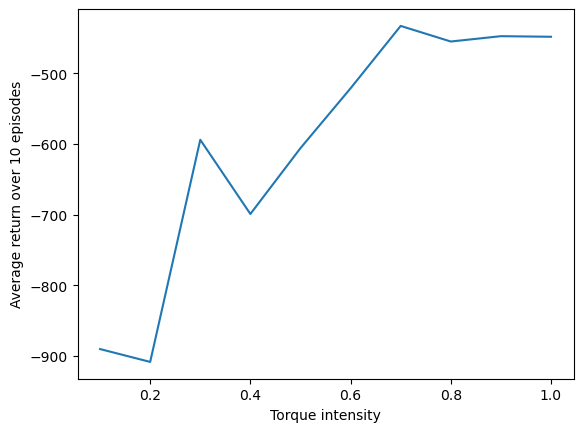

Best torque intensity: 0.7000000000000001
Best reward over 10 episodes: -433.1143177631558


In [5]:
# Find best torque intensity
torque_intensities = np.linspace(0.1, 1, 10)
rewards = []
for torque_intensity in torque_intensities:
    heuristic_agent = HeuristicPendulumAgent(env, torque_intensity=torque_intensity)
    rewards.append(run_agent(heuristic_agent, env, 10))

plt.plot(torque_intensities, rewards)
plt.xlabel('Torque intensity')
plt.ylabel('Average return over 10 episodes')
plt.show()

# Create a HeuristicPendulumAgent with the best torque intensity
heuristic_agent = HeuristicPendulumAgent(env, torque_intensity=torque_intensities[np.argmax(rewards)])
# Print best reward over 10 episodes and associated torque intensity
print('Best torque intensity: {}'.format(torque_intensities[np.argmax(rewards)]))
print('Best reward over 10 episodes: {}'.format(np.max(rewards)))


In [136]:
# Animation of the Heuristic Agent using PIL
state, _ = env.reset()
frames = []
while True:
    action = heuristic_agent.compute_action(state)
    state, reward, _, trunc, _ = env.step(action)
    frames.append(env.render())
    if trunc:
        break

frames = np.array(frames)
frames = [Image.fromarray(frame) for frame in frames]
frames[0].save("heuristic_agent.gif", save_all=True, append_images=frames[1:], duration=50, loop=0)


The environment consists of a pendulum attached to a fixed pivot point. Its position is described by the angle $\alpha$ between the pendulum and the upward vertical direction, and its (angular) velocity is $\dot{\alpha}$. The pendulum is actuated by applying a torque $\tau$ on its pivot point (the action space is thus continuous). The pendulum is subject to gravity, which is the only external force acting on it.

The pendulum starts in a random position, with a random velocity and the aim is to stabilize it in the inverted position, using little torque. More precisely, we want to maximise cummulative reward $-\left(\alpha^2 + 0.1\dot{\alpha}^2 + 0.001\tau^2\right)$ over a time horizon of 200 steps. The pendulum starts in a random position, with a random velocity.

First we will compare two policies: a random policy and a heuristic policy. 
The random policy is a policy that selects actions uniformly at random from the action space, i.e. it applies a tork of random magnitude (within the allowed range)in a random direction.
The heuristic policy is defined as follows:
- When the pendulum is in the lower half of the domain, applies a fixed torque in the same direction as the pendulum's angular velocity;
- When the pendulum is in the upper half of the domain, applies a fixed torque in the opposite direction as the pendulum's angular velocity.

The average return over 10 episodes for the random policy is $\sim (-1300)$, which sets a baseline for the performance of the policies.

On Fig. 1, we see the average return over 10 episodes for the heuristic policy depending on the magnitude of the fixed torque. We can see that the heuristic policy performs better than the random policy for all values of the fixed torque, starting from $\sim (-900)$ for a fixed torque of $0.1$, then increasing to $\sim (-500)$ for a fixed torque of $\sim 0.5$, and then plateauing around $\sim (-450)$ up to a fixed torque of $1$. The best performance lies on this plateau but its exact value varies from one run to another. TODO check the values depending on the seed


## 4 Q function of the heuristic policy

In [6]:
class ReplayBuffer:
    def __init__(self, capacity: int) -> None:
        """Buffer to store transitions.

        A transition is a tuple (state, action, reward, next_state, trunc) where:
            state (np.ndarray[(3,), np.float32]): State of the environment.
            action (np.ndarray[(1,), np.float32]): Action applied to the environment.
            reward (np.ndarray[(1,), np.float32]): Reward obtained after applying the action.
            next_state (np.ndarray[(3,), np.float32]): State of the environment after applying the action.
            trunc (np.ndarray[(1,), np.bool]): Boolean indicating if the episode is truncated.
        
        The buffer is implemented as 5 (one for each element of a transition) cyclic numpy arrays of shape 
        (capacity, *) where * is the shape of the corresponding element of a transition.
        When the buffer is full, the oldest transitions are dropped.
        
        Args:
            capacity (int): Capacity of the buffer.
            transition_type (np.dtype): Type of the transitions to store.
        """
        # Maximum number of transitions to store in the buffer. 
        # When the buffer overflows the old memories are dropped.
        self.capacity = capacity 
        # Numpy array of transitions
        self.states = np.empty((capacity, 3), np.float32)
        self.actions = np.empty((capacity, 1), np.float32)
        self.rewards = np.empty((capacity, 1), np.float32)
        self.next_states = np.empty((capacity, 3), np.float32)
        self.truncs = np.empty((capacity, 1), bool)
        # Index of the next transition to be stored
        self.index = 0
        # Current size of the buffer
        self.size = 0

    def append(self, transition):
        """Add a transition to the buffer.
        
        See constructor docstring for explanation of a transition.
        """
        # Add transition to current index
        self.states[self.index] = transition[0]
        self.actions[self.index] = transition[1]
        self.rewards[self.index] = transition[2]
        self.next_states[self.index] = transition[3]
        self.truncs[self.index] = transition[4]
        # Update index
        self.index = (self.index + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def sample(self, batch_size: int):
        """Sample a batch of size `batch_size` of transitions from the buffers."""
        indexes = np.random.choice(self.size, batch_size, replace=False)
        return self[indexes]

    def __len__(self) -> int:
        return self.size
    
    def __getitem__(self, slice):
        return (self.states[slice], 
                self.actions[slice], 
                self.rewards[slice], 
                self.next_states[slice], 
                self.truncs[slice])


In [7]:
class QNetwork(nn.Module):
    def __init__(self, state_size: int=env.observation_space.shape[0], action_size: int=env.action_space.shape[0]):
        """QNetwork. Maps (state, action) pairs to Q-values."""
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size + action_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, state, action):
        """Forward pass of the network.

        Args:
            state (torch.Tensor): State tensor
            action (torch.Tensor): Action tensor

        Returns:
            q_value (torch.Tensor): Q-value tensor
        """
        x = torch.cat([state, action], dim=-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    


def TD_learning_update(q_network, agent, optimizer, transitions, gamma):
    """Perform a 1-step TD-learning update for a batch of transitions.

    Args:
        q_network (QNetwork): QNetwork instance
        agent (Agent): Agent (i.e. Policy) instance
        optimizer (torch.optim): Optimizer instance
        transitions (List[Transition]): Batch of transitions
        gamma (float): Discount factor

    Returns:
        loss (float): Loss value
    """
    states = transitions[0]
    actions = transitions[1]
    rewards = transitions[2]
    next_states = transitions[3]
    truncs = transitions[4]

    # Convert the numpy arrays to torch tensors
    states_t = torch.from_numpy(states).to(device)
    actions_t = torch.from_numpy(actions).to(device)
    rewards_t = torch.from_numpy(rewards).to(device)
    next_states_t = torch.from_numpy(next_states).to(device)
    truncs_t = torch.from_numpy(truncs).to(device)


    with torch.no_grad():
        next_actions = agent.compute_action(next_states)
        if not torch.is_tensor(next_actions):
            next_actions_t = torch.as_tensor(next_actions)[:, None].to(device, dtype=torch.float32)
        else: next_actions_t = next_actions
        # Naive next Q-values (i.e. without taking truncation into account)
        naive_next_qs = q_network(next_states_t, next_actions_t)
        # Actual next Q-values (i.e. taking truncation into account)
        next_qs = torch.where(truncs_t, 
                              torch.zeros_like(rewards_t), 
                              naive_next_qs)
        gamma = torch.tensor(gamma, dtype=torch.float32)
        targets = rewards_t + gamma * next_qs

    loss = F.mse_loss(q_network(states_t, actions_t), targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss


In [8]:
capacity = 10000 # Capacity of the replay buffer
replay_buffer = ReplayBuffer(capacity=capacity)
q_network = QNetwork(state_size=env.observation_space.shape[0], action_size=env.action_space.shape[0]).to(device)
q_network_before_training = copy.deepcopy(q_network)
optimizer = torch.optim.SGD(q_network.parameters(), lr=1e-4)
gamma = 0.99

# Training loop for the Q-learning
n_episodes = 1000 # Number of episodes
# Number of steps per episode, see documentation of the Pendulum-v1 environment
n_steps = 200
batch_size = 128 # Batch size for the TD-learning update
# Container for the loss of each step of each episode
losses = np.empty((n_episodes, n_steps))
logging_interval = 10
for episode in range(n_episodes):
    state, _ = env.reset()
    step = 0
    while True:
        # Simulation step
        action = heuristic_agent.compute_action(state)
        next_state, reward, _, trunc, _ = env.step(action)
        replay_buffer.append((state, action, reward, next_state, trunc))
        # Training step
        if len(replay_buffer) >= batch_size:
            transitions = replay_buffer.sample(batch_size)
            loss = TD_learning_update(q_network, heuristic_agent, optimizer, transitions, gamma)
            losses[episode, step] = loss.item()
        else:
            losses[episode, step] = np.nan

        if trunc:
            break
        state = next_state
        step += 1
    # Logging average loss of the last episode every `logging_interval` episodes
    if episode % logging_interval == 0 and episode > 0:
        print(f'Episode {episode}/{n_episodes-1}, average loss: {np.mean(losses[episode])}')


Episode 10/999, average loss: 164.69559579849243
Episode 20/999, average loss: 136.66591465950012
Episode 30/999, average loss: 123.43799975395203
Episode 40/999, average loss: 104.07477544784545
Episode 50/999, average loss: 108.97030780792237
Episode 60/999, average loss: 102.4917774772644
Episode 70/999, average loss: 90.97613108158112
Episode 80/999, average loss: 93.90861327648163
Episode 90/999, average loss: 95.03739706993103
Episode 100/999, average loss: 109.54367592811585
Episode 110/999, average loss: 87.50861158847809
Episode 120/999, average loss: 97.58674535274506
Episode 130/999, average loss: 91.47249022483825
Episode 140/999, average loss: 97.91621683120728
Episode 150/999, average loss: 89.33393738746643
Episode 160/999, average loss: 93.50426782608032
Episode 170/999, average loss: 88.3350861120224
Episode 180/999, average loss: 86.25281688690185
Episode 190/999, average loss: 85.28472299575806
Episode 200/999, average loss: 83.15153517007828
Episode 210/999, average

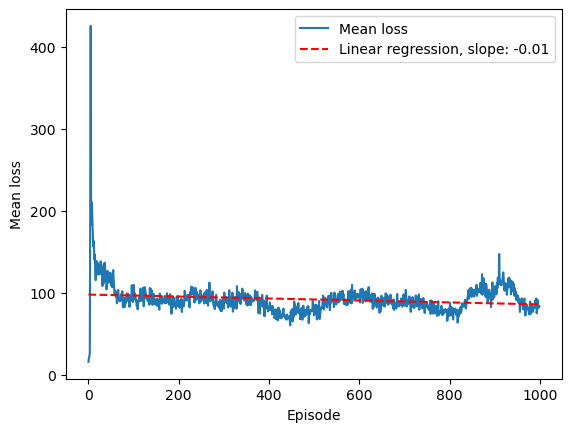

In [9]:
# Plot the mean loss per episode
plt.plot(np.nanmean(losses, axis=1))
# Add linear regression line
x = np.arange(n_episodes)
slope, intercept, r_value, p_value, std_err = stats.linregress(x, np.nanmean(losses, axis=1))
plt.plot(x, slope*x + intercept, 'r--')

# legend
plt.legend(['Mean loss', 'Linear regression, slope: {:.2f}'.format(slope)])

plt.xlabel('Episode')
plt.ylabel('Mean loss')
plt.show()

(100, 100)


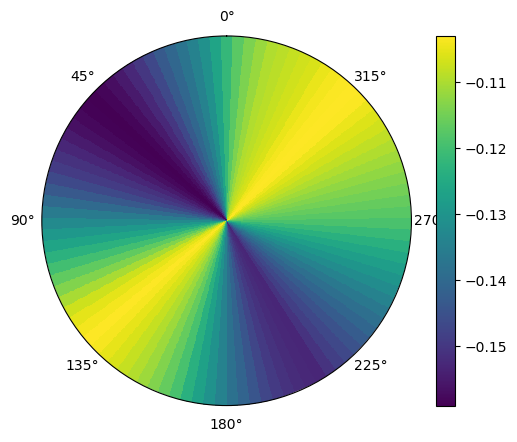

(100, 100)


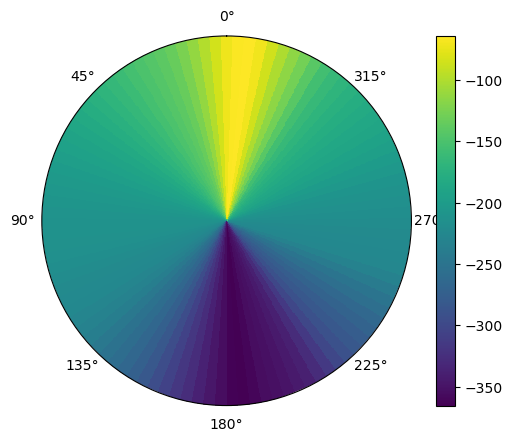

In [141]:
action = -1
velocity = 1

rad = np.linspace(0, 5, 100)
azm = np.linspace(0, 2 * np.pi, 100)
r, th = np.meshgrid(rad, azm)
states = np.empty([100, 100, 3])
states[...,0] = np.cos(th)
states[...,1] = np.sin(th)
states[...,2] = np.full((100,100), velocity)

actions = np.full((100,100, 1), action)


#before training
z = q_network_before_training(torch.Tensor(states), torch.Tensor(actions)).detach().squeeze()

print(np.array(z).shape)


fig = plt.figure()

rad = np.linspace(0, 5, 100)
azm = np.linspace(0, 2 * np.pi, 100)
r, th = np.meshgrid(rad, azm)

ax = plt.subplot(projection="polar")
ax.set_theta_zero_location('N')

ax.set_yticklabels([])

p = plt.pcolormesh(th, r, z)
fig.colorbar(p)

plt.plot(azm, r, color='k', ls='none') 
plt.grid()

plt.show()

#after training
z = q_network(torch.Tensor(states), torch.Tensor(actions)).detach().squeeze()

print(np.array(z).shape)


fig = plt.figure()

rad = np.linspace(0, 5, 100)
azm = np.linspace(0, 2 * np.pi, 100)
r, th = np.meshgrid(rad, azm)

ax = plt.subplot(projection="polar")
ax.set_theta_zero_location('N')

ax.set_yticklabels([])

p = plt.pcolormesh(th, r, z)
fig.colorbar(p)

plt.plot(azm, r, color='k', ls='none') 
plt.grid()

plt.show()

We now implement a critic, i.e. a Q-network, whose goal is to estimate the Q-function of the heuristic policy. We use a neural network with two hidden layers of 32 neurons each, with ReLU activation functions. It is updated using the semi-gradient of the mean squared error between the predicted and target Q-values.

On Fig. 2 we see the training curve with batches of size 128 and 1000 epochs. We can see that the training is very fast, with the loss decreasing to a value of $\sim 0.1$ after only 100 epochs. The loss then decreases very slowly, reaching a value of $\sim 0.05$ after 1000 epochs. This is due to the fact that the heuristic policy is deterministic, so the Q-values are constant and the critic can easily learn them.

 The training is done using the data generated by the heuristic policy, i.e. the states and the corresponding Q-values. The training is done over 1000 epochs, with a batch size of 64.

## 5 Minimal implementation of DDPG

In [142]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_size: int=3, action_size: int=1):
        """PolicyNetwork. Maps states to actions."""
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, action_size)

    def forward(self, state):
        """Forward pass of the network.

        Args:
            state (torch.Tensor): State tensor

        Returns:
            action (torch.Tensor): Action tensor
        """
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        return x

In [143]:
class GaussianActionNoise:
    def __init__(self, sigma: float=0.3):
        assert(sigma>0), 'sigma must be positive'
        self.sigma = sigma

    def get_noisy_action(self, action: torch.Tensor):
        noise = torch.normal(mean=0, std=self.sigma, size=action.shape)
        return torch.clamp(action + noise, -1, +1)
    
class OUActionNoise:
    def __init__(self, theta: float=0.15, sigma: float=0.3):
        assert(theta>=0 and theta<=1), 'theta must be between 0 and 1 (included)'
        assert(sigma>=0), 'sigma must non-negative'
        self.theta = theta
        self.sigma = sigma
        self.noise = torch.zeros(env.action_space.shape[0])
        
    def get_noisy_action(self, action: torch.Tensor):
        self.noise = (1-self.theta)*self.noise + torch.normal(0, self.sigma, size=self.noise.shape)
        return torch.clamp(action + self.noise, -1, +1)


In [144]:
class DDPGAgent:
    def __init__(self, action_noise: 'ActionNoise'=GaussianActionNoise()):
        self.policy_network = PolicyNetwork().to(device)
        self.noise = action_noise
        
    def compute_action(self, state, deterministic=True):
        state_t = torch.from_numpy(state).to(device)
        action = self.policy_network(state_t)
        if not deterministic:
            action = self.noise.get_noisy_action(action)
        return action
    
def policy_learning_update(agent, optimizer, transitions, deterministic: bool=True):
    states = transitions[0]

    # Convert the numpy arrays to torch tensors
    states_t = torch.from_numpy(states).to(device)
    
    
    actions_t = agent.compute_action(states, deterministic)

    # Next Q-values (without taking truncation ??)
    qs = q_network(states_t, actions_t)

    loss = -qs.mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

In [145]:
capacity = 10000 # Capacity of the replay buffer
replay_buffer = ReplayBuffer(capacity=capacity)
q_network = QNetwork(state_size=env.observation_space.shape[0], action_size=env.action_space.shape[0]).to(device)
q_network_before_training = copy.deepcopy(q_network)
action_noise = GaussianActionNoise(sigma=0.3)
agent = DDPGAgent(action_noise=action_noise)
optimizer_q = torch.optim.SGD(q_network.parameters(), lr=1e-4)
optimizer_policy = torch.optim.SGD(agent.policy_network.parameters(), lr=1e-4)
gamma = 0.99

# Training loop for the Q-learning
n_episodes = 100 # Number of episodes
# Number of steps per episode, see documentation of the Pendulum-v1 environment
n_steps = 200
batch_size = 128 # Batch size for the TD-learning update
# Container for the loss of each step of each episode
losses_q = np.empty((n_episodes, n_steps))
losses_policy = np.empty((n_episodes, n_steps))
episode_rewards = np.empty(n_episodes)
logging_interval = 10
for episode in range(n_episodes):
    state, _ = env.reset()
    step = 0
    episode_reward = 0
    while True:
        # Simulation step
        action = agent.compute_action(state, deterministic=False).detach().numpy()
        next_state, reward, _, trunc, _ = env.step(action)
        episode_reward += reward
        replay_buffer.append((state, action, reward, next_state, trunc))
        # Training step
        if len(replay_buffer) >= batch_size:
            transitions = replay_buffer.sample(batch_size)
            loss_q = TD_learning_update(q_network, agent, optimizer_q, transitions, gamma)
            losses_q[episode, step] = loss_q.item()
            loss_policy = policy_learning_update(agent, optimizer_policy, transitions, deterministic=False)
            losses_policy[episode, step] = loss_policy.item()
        else:
            losses_q[episode, step] = np.nan
            losses_policy[episode, step] = np.nan

        if trunc:
            break
        state = next_state
        step += 1
    episode_rewards[episode] = episode_reward
    # Logging average loss of the last episode every `logging_interval` episodes
    if episode % logging_interval == 0 and episode > 0:
        print(f'Episode {episode}/{n_episodes-1}, average loss q-network: {np.mean(losses_q[episode])}, average loss policy network: {np.mean(losses_policy[episode])}')


def train_ddpg(agent, q_network, optimizer_q, optimizer_policy, n_episodes: int=1000, 
               batch_size: int=128, gamma: float=0.99, logging_interval: int=10, 
               capacity: int=10000):
    """Train the DDPG agent.

    Args:
        agent (DDPGAgent): The agent to train.
        q_network (QNetwork): The Q-network to train.
        optimizer_q (torch.optim.Optimizer): The optimizer for the Q-network.
        optimizer_policy (torch.optim.Optimizer): The optimizer for the policy network.
        n_episodes (int, optional): Number of episodes to train. Defaults to 1000.
        batch_size (int, optional): Batch size for the TD-learning update. Defaults to 128.
        gamma (float, optional): Discount factor. Defaults to 0.99.
        logging_interval (int, optional): Logging interval. Defaults to 10.
        capacity (int, optional): Capacity of the replay buffer. Defaults to 10000.
    
    Returns:
        (np.ndarray, np.ndarray, np.ndarray): The losses of the Q-network, the losses of the policy network and the episode rewards.
    """
    # Number of steps per episode, see documentation of the Pendulum-v1 environment
    n_steps = 200
    replay_buffer = ReplayBuffer(capacity=capacity)
    # Container for the loss of each step of each episode
    losses_q = np.empty((n_episodes, n_steps))
    losses_policy = np.empty((n_episodes, n_steps))
    episode_rewards = np.empty(n_episodes)
    for episode in range(n_episodes):
        state, _ = env.reset()
        step = 0
        episode_reward = 0
        while True:
            # Simulation step
            action = agent.compute_action(state, deterministic=False).detach().numpy()
            next_state, reward, _, trunc, _ = env.step(action)
            episode_reward += reward
            replay_buffer.append((state, action, reward, next_state, trunc))
            # Training step
            if len(replay_buffer) >= batch_size:
                transitions = replay_buffer.sample(batch_size)
                loss_q = TD_learning_update(q_network, agent, optimizer_q, transitions, gamma)
                losses_q[episode, step] = loss_q.item()
                # TODO ask deterministic or not
                loss_policy = policy_learning_update(agent, optimizer_policy, transitions, deterministic=False)
                losses_policy[episode, step] = loss_policy.item()
            else:
                losses_q[episode, step] = np.nan
                losses_policy[episode, step] = np.nan

            if trunc:
                break
            state = next_state
            step += 1
        episode_rewards[episode] = episode_reward
        # Logging average loss of the last episode every `logging_interval` episodes
        if episode % logging_interval == 0 and episode > 0:
            print(f'Episode {episode}/{n_episodes-1}, average loss q-network: {np.mean(losses_q[episode])}, average loss policy network: {np.mean(losses_policy[episode])}')

    return losses_q, losses_policy, episode_rewards

Episode 10/99, average loss q-network: 1256.0093568134307, average loss policy network: 464.05474838256833
Episode 20/99, average loss q-network: 1031.2631101417542, average loss policy network: 466.3776982116699
Episode 30/99, average loss q-network: 976.0659015035629, average loss policy network: 408.31370025634766
Episode 40/99, average loss q-network: 946.8562676715851, average loss policy network: 411.6112564086914
Episode 50/99, average loss q-network: 889.6361570167542, average loss policy network: 387.2491670227051
Episode 60/99, average loss q-network: 616.6897681331634, average loss policy network: 366.4312075805664
Episode 70/99, average loss q-network: 576.3433180475236, average loss policy network: 350.5121598815918
Episode 80/99, average loss q-network: 438.21165133953093, average loss policy network: 307.98157775878906
Episode 90/99, average loss q-network: 383.35325595378873, average loss policy network: 284.38641235351565


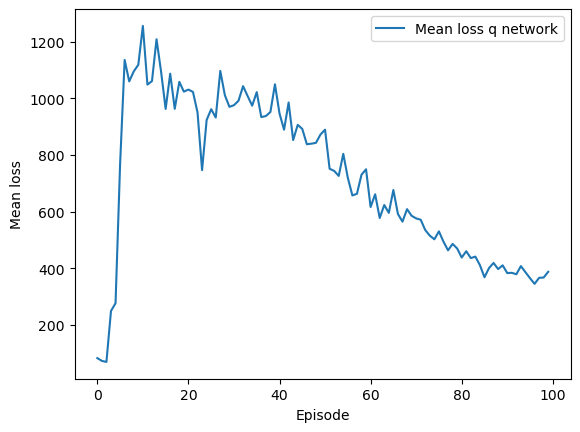

In [146]:
# Plot the mean loss of q network per episode
plt.plot(np.nanmean(losses_q, axis=1))

# legend
plt.legend(['Mean loss q network'])

plt.xlabel('Episode')
plt.ylabel('Mean loss')
plt.show()

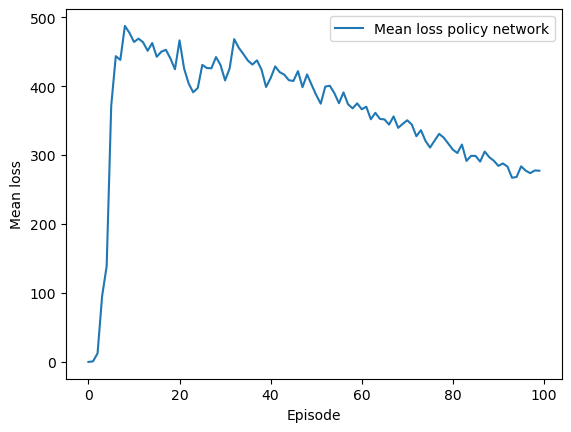

In [147]:
# Plot the mean loss of policy network per episode
plt.plot(np.nanmean(losses_policy, axis=1))

# legend
plt.legend(['Mean loss policy network'])

plt.xlabel('Episode')
plt.ylabel('Mean loss')
plt.show()

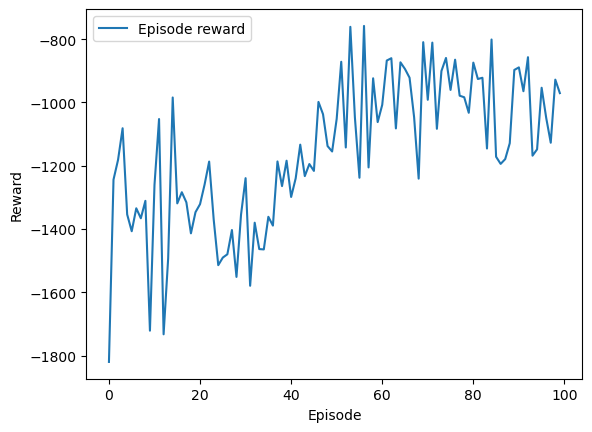

In [148]:
# Plot the episode reward for each episode
plt.plot(episode_rewards)

# legend
plt.legend(['Episode reward'])

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

In [149]:
n_episodes = 100
episode_rewards = np.empty(n_episodes)
for episode in range(n_episodes):
    episode_reward = 0
    state, _ = env.reset()
    while True:
        action = agent.compute_action(state, deterministic=False).detach().numpy()
        next_state, reward, _, trunc, _ = env.step(action)
        episode_reward += reward
        if trunc:
            break
        state = next_state

    episode_rewards[episode] = episode_reward

print('Average reward over 100 episodes: {}'.format(np.mean(episode_rewards)))
print(episode_rewards)

Average reward over 100 episodes: -874.8004242261231
[ -866.88044858  -882.13831812  -874.75948381  -985.04609755
  -761.50827975  -987.50787999  -923.30707919  -994.08089153
  -763.10774424  -743.20850017  -810.91778769  -911.3243748
  -899.15055791  -882.65198018  -764.48012684  -872.28642987
  -895.40650631  -853.83202688  -767.63716226  -864.726281
  -767.75113763  -861.95937266  -890.13440598  -869.1465188
  -890.66246059  -901.5102575   -881.52138482  -774.79598551
  -993.67309858  -750.56906586  -801.79064561  -860.44928227
  -904.02387341  -742.3344024   -887.50121643  -867.8369649
  -867.72738188  -987.30947358  -863.11123137  -989.86799297
 -1004.12111028  -985.37260531  -787.92863629  -886.08874769
  -749.14746146  -895.32631058  -768.20554798  -696.47250188
  -856.94837784  -894.45847039  -875.7225724   -769.85466441
  -757.71447223  -764.91119112  -896.20783355  -970.79985062
  -881.9881279   -898.54807568  -873.44522531  -887.0053494
  -864.74382607  -753.39893206  -984.8

(100, 100)


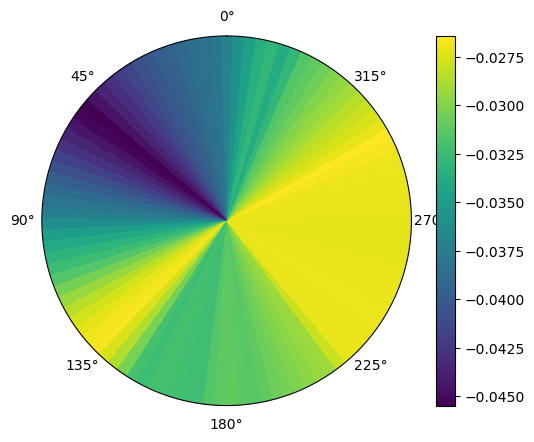

(100, 100)


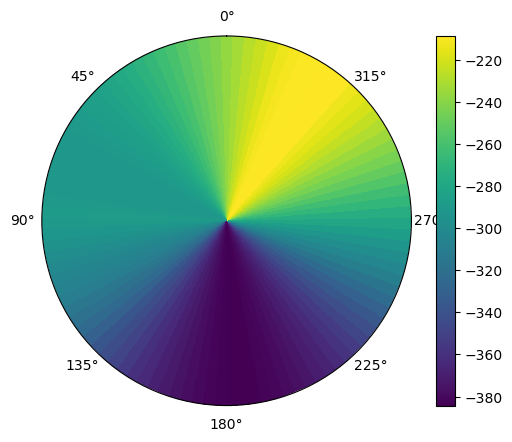

In [150]:
action = -1
velocity = 2

rad = np.linspace(0, 5, 100)
azm = np.linspace(0, 2 * np.pi, 100)
r, th = np.meshgrid(rad, azm)
states = np.empty([100, 100, 3])
states[...,0] = np.cos(th)
states[...,1] = np.sin(th)
states[...,2] = np.full((100,100), velocity)

actions = np.full((100,100, 1), action)


#before training
z = q_network_before_training(torch.Tensor(states), torch.Tensor(actions)).detach().squeeze()

print(np.array(z).shape)


fig = plt.figure()

rad = np.linspace(0, 5, 100)
azm = np.linspace(0, 2 * np.pi, 100)
r, th = np.meshgrid(rad, azm)

ax = plt.subplot(projection="polar")
ax.set_theta_zero_location('N')

ax.set_yticklabels([])

p = plt.pcolormesh(th, r, z)
fig.colorbar(p)

plt.plot(azm, r, color='k', ls='none') 
plt.grid()

plt.show()

#after training
z = q_network(torch.Tensor(states), torch.Tensor(actions)).detach().squeeze()

print(np.array(z).shape)


fig = plt.figure()

rad = np.linspace(0, 5, 100)
azm = np.linspace(0, 2 * np.pi, 100)
r, th = np.meshgrid(rad, azm)

ax = plt.subplot(projection="polar")
ax.set_theta_zero_location('N')

ax.set_yticklabels([])

p = plt.pcolormesh(th, r, z)
fig.colorbar(p)

plt.plot(azm, r, color='k', ls='none') 
plt.grid()

plt.show()

In [151]:
transitions = replay_buffer.sample(batch_size)
velocities = transitions[0][:,2]
print(velocities.max())
#save model and losses
"""
torch.save(q_network.state_dict(), "5_q_network.pt")
torch.save(agent.policy_network.state_dict(), "5_policy_network.pt")
np.save("5_q_loss.txt", losses_q)
np.save("5_policy_loss.txt", losses_policy)
np.save("5_rewards.txt", episode_rewards)
"""

8.0


'\ntorch.save(q_network.state_dict(), "5_q_network.pt")\ntorch.save(agent.policy_network.state_dict(), "5_policy_network.pt")\nnp.save("5_q_loss.txt", losses_q)\nnp.save("5_policy_loss.txt", losses_policy)\nnp.save("5_rewards.txt", episode_rewards)\n'

## 6. Target networks

In [152]:
class DDPGAgentWithTargetNetwork:
    def __init__(self, action_noise: 'ActionNoise'=GaussianActionNoise()):
        self.policy_network = PolicyNetwork().to(device)
        self.target_policy_network = copy.deepcopy(self.policy_network).to(device)
        self.target_policy_network = PolicyNetwork().to(device)
        self.target_policy_network.load_state_dict(self.policy_network.state_dict())
        self.noise = action_noise
        
    def compute_action(self, state, target=False, deterministic=True):
        state_t = torch.from_numpy(state).to(device)
        if target:
            action = self.target_policy_network(state_t)
        else:
            action = self.policy_network(state_t)
        if not deterministic:
            action = self.noise.get_noisy_action(action)
        return action

def policy_learning_update_with_target(agent, optimizer, transitions, deterministic: bool=True):
    states = transitions[0]

    # Convert the numpy arrays to torch tensors
    states_t = torch.from_numpy(states).to(device)
    
    
    actions_t = agent.compute_action(states, target=False, deterministic=deterministic)

    # Next Q-values (without taking truncation ??)
    qs = q_network(states_t, actions_t)

    loss = -qs.mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

In [153]:
def TD_learning_update_with_target_networks(q_network, target_q_network, agent, optimizer, transitions, gamma):
    """Perform a 1-step TD-learning update for a batch of transitions.

    Args:
        q_network (QNetwork): QNetwork instance
        agent (Agent): Agent (i.e. Policy) instance
        optimizer (torch.optim): Optimizer instance
        transitions (List[Transition]): Batch of transitions
        gamma (float): Discount factor

    Returns:
        loss (float): Loss value
    """
    states = transitions[0]
    actions = transitions[1]
    rewards = transitions[2]
    next_states = transitions[3]
    truncs = transitions[4]

    # Convert the numpy arrays to torch tensors
    states_t = torch.from_numpy(states).to(device)
    actions_t = torch.from_numpy(actions).to(device)
    rewards_t = torch.from_numpy(rewards).to(device)
    next_states_t = torch.from_numpy(next_states).to(device)
    truncs_t = torch.from_numpy(truncs).to(device)


    with torch.no_grad():
        next_actions = agent.compute_action(next_states, target=True, deterministic=True)
        if not torch.is_tensor(next_actions):
            next_actions_t = torch.as_tensor(next_actions)[:, None].to(device, dtype=torch.float32)
        else: next_actions_t = next_actions
        # Naive next Q-values (i.e. without taking truncation into account)
        naive_next_qs = target_q_network(next_states_t, next_actions_t)
        # Actual next Q-values (i.e. taking truncation into account)
        next_qs = torch.where(truncs_t, 
                              torch.zeros_like(rewards_t), 
                              naive_next_qs)
        gamma = torch.tensor(gamma, dtype=torch.float32)
        targets = rewards_t + gamma * next_qs

    loss = F.mse_loss(q_network(states_t, actions_t), targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

In [154]:
def target_learning(network, target_network, tau):
    target_network_state_dict = target_network.state_dict()
    network_state_dict = network.state_dict()
    for key in network_state_dict:
        target_network_state_dict[key] = network_state_dict[key]*tau + target_network_state_dict[key]*(1-tau)
    target_network.load_state_dict(target_network_state_dict)

In [155]:
#TODO train for 5 different values of tau between 0.01 and 1
capacity = 10000 # Capacity of the replay buffer
replay_buffer = ReplayBuffer(capacity=capacity)
q_network = QNetwork(state_size=env.observation_space.shape[0], action_size=env.action_space.shape[0]).to(device)
target_q_network = QNetwork(state_size=env.observation_space.shape[0], action_size=env.action_space.shape[0]).to(device)
target_q_network.load_state_dict(q_network.state_dict())
q_network_before_training = copy.deepcopy(q_network)
action_noise = GaussianActionNoise(sigma=0.3)
agent = DDPGAgentWithTargetNetwork(action_noise=action_noise)
optimizer_q = torch.optim.SGD(q_network.parameters(), lr=1e-4)
optimizer_policy = torch.optim.SGD(agent.policy_network.parameters(), lr=1e-4)
gamma = 0.99
tau = 0.05

# Training loop for the Q-learning
n_episodes = 100 # Number of episodes
# Number of steps per episode, see documentation of the Pendulum-v1 environment
n_steps = 200
batch_size = 128 # Batch size for the TD-learning update
# Container for the loss of each step of each episode
losses_q = np.empty((n_episodes, n_steps))
losses_policy = np.empty((n_episodes, n_steps))
episode_rewards = np.empty(n_episodes)
logging_interval = 10
for episode in range(n_episodes):
    state, _ = env.reset()
    step = 0
    episode_reward = 0
    while True:
        # Simulation step
        action = agent.compute_action(state, target=False, deterministic=False).detach().numpy()
        next_state, reward, _, trunc, _ = env.step(action)
        episode_reward += reward
        replay_buffer.append((state, action, reward, next_state, trunc))
        # Training step
        if len(replay_buffer) >= batch_size:
            transitions = replay_buffer.sample(batch_size)
            loss_q = TD_learning_update_with_target_networks(q_network, target_q_network, agent, optimizer_q, transitions, gamma)
            losses_q[episode, step] = loss_q.item()
            # TODO ask deterministic or not
            loss_policy = policy_learning_update_with_target(agent, optimizer_policy, transitions, deterministic=True)
            losses_policy[episode, step] = loss_policy.item()

            # Update of the target networks
            target_learning(q_network, target_q_network, tau=tau)
            target_learning(agent.policy_network, agent.target_policy_network, tau=tau)
        else:
            losses_q[episode, step] = np.nan
            losses_policy[episode, step] = np.nan

        if trunc:
            break
        state = next_state
        step += 1
    episode_rewards[episode] = episode_reward
    # Logging average loss of the last episode every `logging_interval` episodes
    if episode % logging_interval == 0 and episode > 0:
        print(f'Episode {episode}/{n_episodes-1}, average loss q-network: {np.mean(losses_q[episode])}, average loss policy network: {np.mean(losses_policy[episode])}')

Episode 10/99, average loss q-network: 528.5176252460479, average loss policy network: 285.1755396270752
Episode 20/99, average loss q-network: 909.4310308456421, average loss policy network: 343.8590234375
Episode 30/99, average loss q-network: 1195.3315999603271, average loss policy network: 346.40704696655274
Episode 40/99, average loss q-network: 960.8149524831772, average loss policy network: 346.48500579833984
Episode 50/99, average loss q-network: 1086.918352251053, average loss policy network: 340.50002883911134
Episode 60/99, average loss q-network: 1124.3310238647462, average loss policy network: 310.83902252197265
Episode 70/99, average loss q-network: 968.9210255146027, average loss policy network: 282.81522468566897
Episode 80/99, average loss q-network: 1081.4882581043244, average loss policy network: 301.1847095489502
Episode 90/99, average loss q-network: 999.0579936313629, average loss policy network: 353.8977046203613


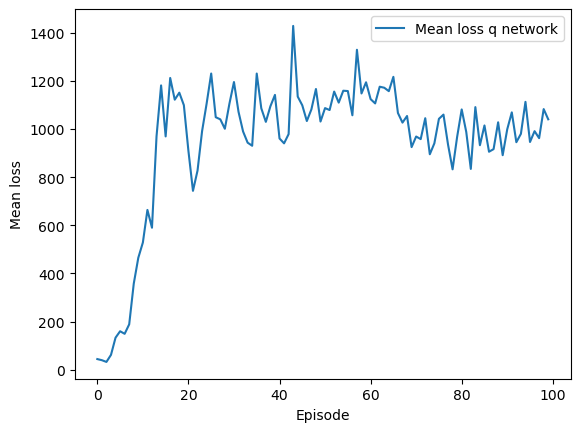

In [156]:
# Plot the mean loss of q network per episode
plt.plot(np.nanmean(losses_q, axis=1))

# legend
plt.legend(['Mean loss q network'])

plt.xlabel('Episode')
plt.ylabel('Mean loss')
plt.show()

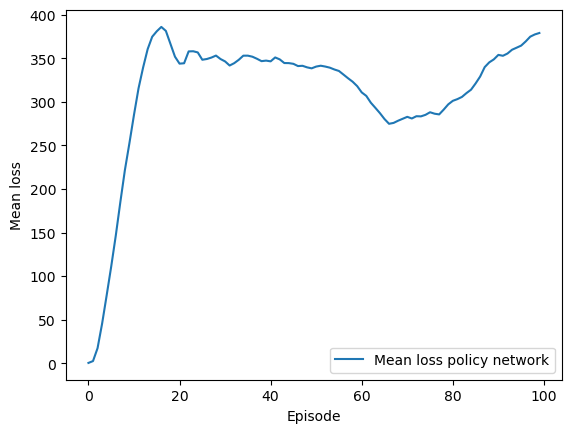

[[         nan          nan          nan ...   0.65402019   0.66559756
    0.68014157]
 [  0.6768778    0.67916423   0.69260716 ...   6.95419025   7.02365303
    7.32290173]
 [  7.3180151    6.90272379   7.29384422 ...  30.81932831  30.07392883
   26.17158508]
 ...
 [360.89373779 372.80987549 362.54623413 ... 365.02453613 391.18630981
  349.06900024]
 [394.59393311 362.81814575 393.50457764 ... 348.26663208 395.88131714
  356.39199829]
 [400.08633423 343.74060059 405.33248901 ... 358.54980469 390.03305054
  344.07937622]]


In [157]:
# Plot the mean loss of policy network per episode
plt.plot(np.nanmean(losses_policy, axis=1))

# legend
plt.legend(['Mean loss policy network'])

plt.xlabel('Episode')
plt.ylabel('Mean loss')
plt.show()
print(losses_policy[:200])

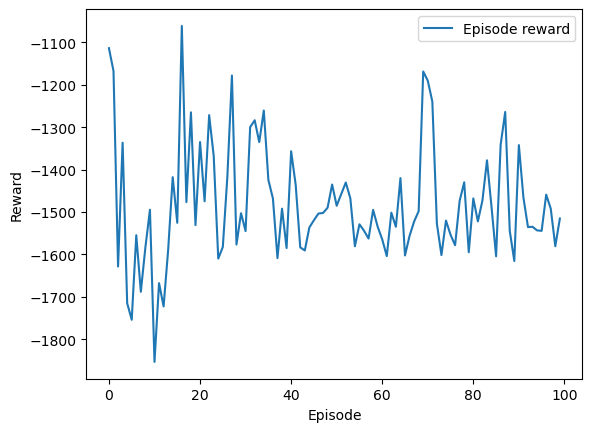

In [158]:
# Plot the episode reward for each episode
plt.plot(episode_rewards)

# legend
plt.legend(['Episode reward'])

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

In [159]:
n_episodes = 100
episode_rewards = np.empty(n_episodes)
for episode in range(n_episodes):
    episode_reward = 0
    state, _ = env.reset()
    while True:
        action = agent.compute_action(state, target=False, deterministic=False).detach().numpy()
        next_state, reward, _, trunc, _ = env.step(action)
        episode_reward += reward
        if trunc:
            break
        state = next_state
        episode_rewards[episode] = episode_reward
        
        print('Average reward over 100 episodes: {}'.format(np.mean(episode_rewards)))

Average reward over 100 episodes: 49.49409247448566
Average reward over 100 episodes: 49.487581857033774
Average reward over 100 episodes: 49.47877607003512
Average reward over 100 episodes: 49.4652075960522
Average reward over 100 episodes: 49.44390263926397
Average reward over 100 episodes: 49.41172937452027
Average reward over 100 episodes: 49.36352544514962
Average reward over 100 episodes: 49.29375742329803
Average reward over 100 episodes: 49.196614781342625
Average reward over 100 episodes: 49.067039329303036
Average reward over 100 episodes: 48.91355658021072
Average reward over 100 episodes: 48.76587029304118
Average reward over 100 episodes: 48.63971086643598
Average reward over 100 episodes: 48.534013380310974
Average reward over 100 episodes: 48.44870330337173
Average reward over 100 episodes: 48.380635867012664
Average reward over 100 episodes: 48.32645543123115
Average reward over 100 episodes: 48.28231071260639
Average reward over 100 episodes: 48.244232955771075
Average

In [160]:
# Animation of the Heuristic Agent using PIL
"""
state, _ = env.reset()
frames = []
while True:
    action = agent.compute_action(state, target=False, deterministic=True).detach().numpy()
    state, reward, _, trunc, _ = env.step(action)
    frames.append(env.render())
    if trunc:
        break

frames = np.array(frames)
frames = [Image.fromarray(frame) for frame in frames]
frames[0].save("agent.gif", save_all=True, append_images=frames[1:], duration=50, loop=0)
"""

'\nstate, _ = env.reset()\nframes = []\nwhile True:\n    action = agent.compute_action(state, target=False, deterministic=True).detach().numpy()\n    state, reward, _, trunc, _ = env.step(action)\n    frames.append(env.render())\n    if trunc:\n        break\n\nframes = np.array(frames)\nframes = [Image.fromarray(frame) for frame in frames]\nframes[0].save("agent.gif", save_all=True, append_images=frames[1:], duration=50, loop=0)\n'

# 7 Ornstein-Uhlenbeck noise

In [161]:
thetas = [0, 0.25, 0.5, 0.75, 1]
for theta in thetas:
    q_network = QNetwork().to(device)
    action_noise = OUActionNoise(theta=theta, sigma=0.3)
    agent = DDPGAgent(action_noise=action_noise)
    optimizer_q = torch.optim.SGD(q_network.parameters(), lr=1e-4)
    optimizer_policy = torch.optim.SGD(agent.policy_network.parameters(), lr=1e-4)
    losses_q, losses_policy, episode_rewards = train_ddpg(
        agent, q_network, optimizer_q, optimizer_policy, n_episodes=100, batch_size=128, 
        gamma=0.99, capacity=10000, logging_interval=100)